In [1]:
import itertools, copy
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [3]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [4]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
df0 = df0.set_index('seq')
humanaaprobdict = np.log(df0['freq']).to_dict()
humanaaprobdict

df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log(count).to_dict()

In [5]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log(count).to_dict()

In [6]:
h = copy.deepcopy(humanaaprobdict)
J0 = dict(zip(aminoacids, [dict(zip(aminoacids, np.zeros(len(aminoacids))))]*len(aminoacids)))
Jk = [J0, copy.deepcopy(J0)]

In [7]:
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=3)]))

In [8]:
np.exp(-energy_ising('ACL', h, Jk))/Z

0.00016062054578543723

In [9]:
print(np.exp(loglikelihood_independent('ACL', humanaaprobdict)))
print(np.exp(loglikelihood_mc('ACL', humanaaprobdict, humandoubletprobdict)))
print(np.exp(loglikelihood_triplet('ACL', humanaaprobdict, humandoubletprobdict, humantripletprobdict)))

0.0001606189778362446
0.00013991001867381708
0.0001452302456227127


In [10]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')

In [11]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')

In [12]:
dfgap2 = counter_to_df(count_kmers_proteome(human, 2, gap=2))
dfgap2 = dfgap2[~dfgap2['seq'].str.contains('U|B|X|Z')]
dfgap2 = dfgap2.set_index('seq')

In [13]:
def fit_ising(f1, f2s, niter=1, nmcmc=1e6, epsilon=0.1, Jk=None):
    h = np.log(f1['freq']).to_dict()
    aas_arr = np.array(list(aminoacids))
    if Jk is None:
        J0 = np.zeros((len(aminoacids), len(aminoacids)))
        J0 = pd.DataFrame(np.asarray(J0), index=list(aminoacids), columns=list(aminoacids)).to_dict()
        Jk = [J0]
        for gap in range(1, len(f2s)):
            Jk.append(copy.deepcopy(J0))
    for i in range(niter):
        jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
        x0 = jump(None)
        samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, nmcmc)
        for gap in range(len(f2s)):
            m = f2s[gap].merge(counter_to_df(count_kmers_iterable(samples, 2, gap=gap)), left_index=True, right_on='seq')
            m['logfold'] = np.log(m['freq_x']/m['freq_y'])
            print(i, gap, np.mean(np.abs(m['logfold'])))
            for idx, row in m.iterrows():
                logfold = row['logfold']
                aa1 = row['seq'][0]
                aa2 = row['seq'][1]
                Jk[gap][aa1][aa2] += logfold * epsilon
    return h, Jk

In [14]:
h, Jk = fit_ising(df0, [df1, dfgap1, dfgap2], nmcmc=1e5, niter=30, epsilon=0.2)

0 0 0.11716685670244743
0 1 0.10053013560816602
0 2 0.11218454242386908
1 0 0.09737271415472945
1 1 0.08615413368542889
1 2 0.09440101942289404
2 0 0.08617015002256774
2 1 0.07864835958202032
2 2 0.08801323623795489
3 0 0.08110348238234369
3 1 0.08077608642667014
3 2 0.08666215675519026
4 0 0.06665536807488191
4 1 0.06774869835269567
4 2 0.08458344124289877
5 0 0.0639250353431854
5 1 0.06551812773989485
5 2 0.07827602835977275
6 0 0.062151501727123054
6 1 0.06874361749420217
6 2 0.073266311003257
7 0 0.06325848656825957
7 1 0.07163900132670677
7 2 0.08014393787795235
8 0 0.05914963814813035
8 1 0.06743255418466589
8 2 0.07246661283183004
9 0 0.05694627785899922
9 1 0.06805545070317588
9 2 0.07381131400622006
10 0 0.060049813429160326
10 1 0.06699509731891712
10 2 0.07598298740742304
11 0 0.057452208681316314
11 1 0.06302847153707448
11 2 0.07622163414872568
12 0 0.06162996495697395
12 1 0.06986876137093453
12 2 0.07681428717898232
13 0 0.059360312036812114
13 1 0.06433828335195411
13 2

In [15]:
jump = lambda x: ''.join(np.random.choice(list(aminoacids), size=8))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, 1e6)

0.020610874366000467

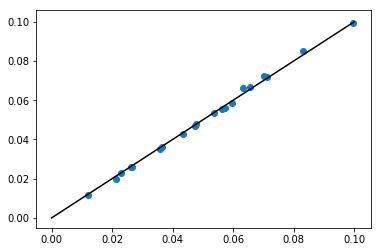

In [16]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.03451689970655451

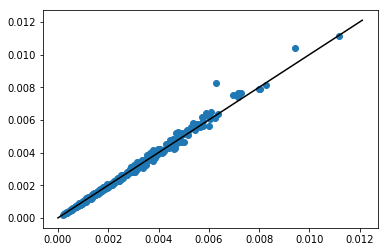

In [17]:
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.0382011511416128

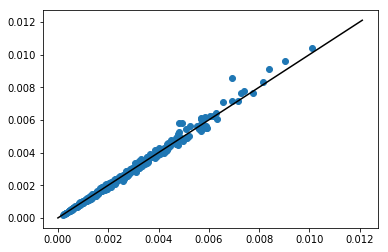

In [18]:
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.039999115853535244

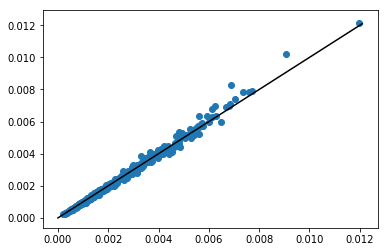

In [19]:
dfmgap2 = dfgap2.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

In [20]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

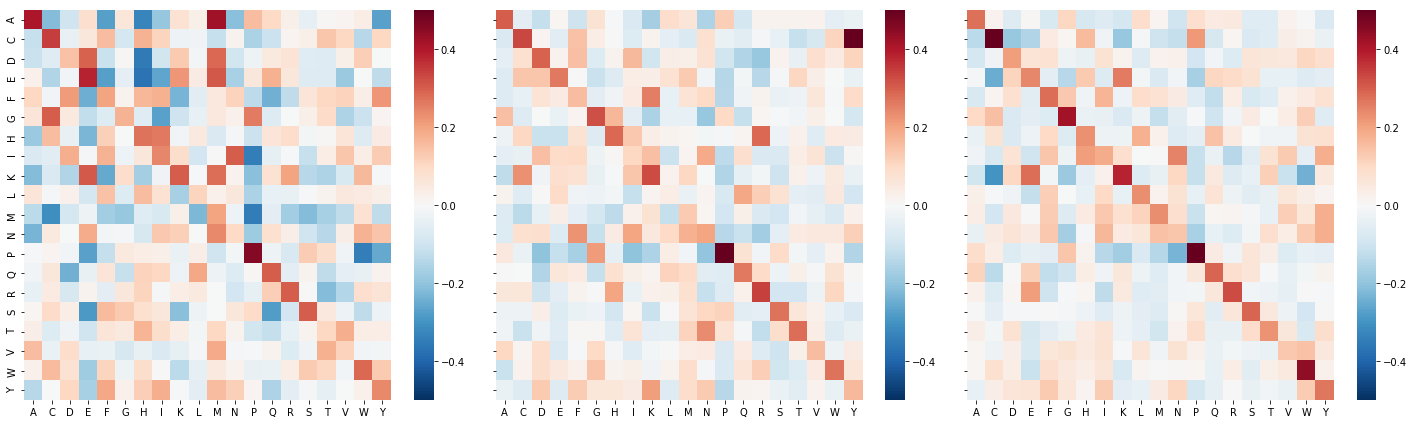

In [21]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [22]:
k = 4
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([float(df.loc[''.join(s)]) for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=k)]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([np.exp(loglikelihood_triplet(s, humanaaprobdict,
                                             humandoubletprobdict,
                                             humantripletprobdict)) for s in kmers])
mc = np.array([np.exp(loglikelihood_mc(s, humanaaprobdict,
                                          humandoubletprobdict)) for s in kmers])
ind = np.array([np.exp(loglikelihood_independent(s, humanaaprobdict)) for s in kmers])

(0.939688111252018, 0.9274655307870588, 0.8821731898433343, 0.8232060016090637)

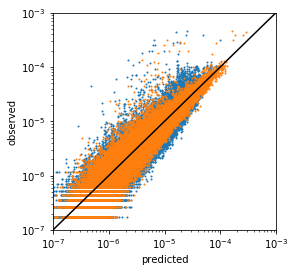

In [23]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1)
#plt.scatter(mc, exp, s=1)
plt.scatter(ising, exp, s=1)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.xscale('log')
plt.yscale('log')
np.corrcoef(tri, exp)[1, 0], np.corrcoef(ising, exp)[1, 0], np.corrcoef(mc, exp)[1, 0], np.corrcoef(ind, exp)[1, 0]

In [75]:
pd.DataFrame(index=[key for key in h], data=[h[key] for key in h], columns=['h'])

,h
M,-3.848107
T,-2.926988
G,-2.722314
Y,-3.624615
P,-2.762818
D,-3.049282
E,-2.644430
K,-2.860134
L,-2.306518
R,-2.874816


In [61]:
itertools.repeat?

In [65]:
doublets = [''.join(s) for s in itertools.product(list(aminoacids), repeat=2)]

In [73]:
df = pd.DataFrame(index=doublets, data=[Jk[0][s[0]][s[1]] for s in doublets], columns=['J0'])
for i in range(1, len(Jk)):
    df['J%g'%i] = [Jk[i][s[0]][s[1]] for s in doublets]

In [44]:
from functools import reduce

In [74]:
df

,J0,J1,J2
AA,0.408351,0.302581,0.276144
AC,-0.114552,-0.070776,-0.135173
AD,-0.110865,-0.050536,-0.088408
AE,0.025382,-0.066199,-0.011524
AF,0.104082,-0.065800,-0.080903
AG,0.065605,0.150684,0.097671
AH,-0.184821,-0.026055,-0.032432
AI,-0.071128,-0.046924,-0.021163
AK,-0.218065,-0.126603,-0.094453
AL,0.066013,0.017061,0.028768


In [54]:
reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), [pd.DataFrame.from_dict(
    {i+j: Jk[gap][i][j] for i in Jk[gap].keys() for j in Jk[gap][i].keys()},
    orient='index')
           for gap in range(len(Jk))])

,0_x,0_y,0
AA,0.408351,0.302581,0.276144
AC,-0.114552,-0.070776,-0.135173
AD,-0.110865,-0.050536,-0.088408
AE,0.025382,-0.066199,-0.011524
AF,0.104082,-0.065800,-0.080903
AG,0.065605,0.150684,0.097671
AH,-0.184821,-0.026055,-0.032432
AI,-0.071128,-0.046924,-0.021163
AK,-0.218065,-0.126603,-0.094453
AL,0.066013,0.017061,0.028768


In [49]:
pd.merge?